In [ ]:
%pip install graphdatascience python-dotenv shap

# Exploring Fraud Detection With Neo4j & Graph Data Science

This analysis uses [Neo4j and Graph Data Science (GDS)](https://neo4j.com/docs/graph-data-science/current/) to explore an anonymized data sample from a Peer-to-Peer (P2P) payment platform.  The notebook is split up into the following sections to cover various stages of the graph data science workflow:

- Notebook Setup
- Part 1: Exploring Connected Fraud Data
- Part 2: Resolving Fraud Communities using Entity Resolution and Community Detection
- Part 3: Recommending Suspicious Accounts With Centrality & Node Similarity
- Part 4: Predicting Fraud Risk Accounts with Machine Learning

## Notebook Setup <a name="p0"></a>

In [2]:
import pandas as pd
from graphdatascience import GraphDataScience
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import shap

pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 50)

### Neo4j Settings

In [3]:
HOST = 'neo4j+s://4fde170f.databases.neo4j.io'
USERNAME = 'neo4j'
PASSWORD = '6pJpSppiL2KRUEuGBOn8RAGcj4QSMKG3B2lEMymLXnk'

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience(
    HOST,
    auth=(USERNAME, PASSWORD),
    aura_ds=True
)

### Helper Functions

In [4]:
def clear_graph_by_name(g_name):
    if gds.graph.exists(g_name).exists:
        g = gds.graph.get(g_name)
        gds.graph.drop(g)

def clear_all_graphs():
    g_names = gds.graph.list().graphName.tolist()
    for g_name in g_names:
        g = gds.graph.get(g_name)
        gds.graph.drop(g)

def identifier_degrees(user_label, degree_property):
    g_name = 'id-projection'
    clear_graph_by_name(g_name)
    g, _  = gds.graph.project(g_name, [user_label, 'Card', 'Device', 'IP'],{
        'HAS_CC': {'orientation': 'REVERSE'},
        'HAS_IP': {'orientation': 'REVERSE'},
        'USED': {'orientation': 'REVERSE'}
    })
    gds.degree.mutate(g, mutateProperty=degree_property)
    gds.graph.writeNodeProperties(g, [degree_property], ['Card', 'Device', 'IP'])
    g.drop()

## Part 1: Exploring Connected Fraud Data

### Dataset Introduction

We will be using an anonymized sample of user accounts and transactions from a real-world Peer-to-Peer (P2P) platform. Prior to ingesting the data into graph, the original identification numbers were removed and categorical values were masked. Each user account has a unique 128-bit identifier, while the other nodes, representing unique credit cards, devices, and ip addresses have been assigned random UUIDs. These identifier are stored as the guid property in the graph schema.

Each user node has an indicator variable for money transfer fraud (named MoneyTransferFraud) that is 1 for known fraud and 0 otherwise. This indicator is determined by a combination of credit card chargeback events and manual review. A chargeback is an action taken by a bank to reverse electronic payments. It involves reversing a payment and triggering a dispute resolution process, often for billing errors and unauthorized credit use. In short, a user must have at least one chargeback to be considered fraudulent. Only a small proportion of the user accounts, roughly 0.7 %, are flagged for fraud.

Each user node has an indicator variable for money transfer fraud (named `MoneyTransferFraud`) that is 1 for known fraud and 0 otherwise. This indicator is determined by a combination of credit card chargeback events and manual review. A chargeback is an action taken by a bank to reverse electronic payments. It involves reversing a payment and triggering a dispute resolution process, often for billing errors and unauthorized credit use. In short, a user must have at least one chargeback to be considered fraudulent. Only a small proportion of the user accounts, roughly 0.7 %, are flagged for fraud.


Below is a breakdown of high-level counts by labels and relationships as well as the flagged accounts.

In [5]:
# total node counts
gds.run_cypher('''
    CALL apoc.meta.stats()
    YIELD labels
    UNWIND keys(labels) AS nodeLabel
    RETURN nodeLabel, labels[nodeLabel] AS nodeCount
''')

,nodeLabel,nodeCount
0,User,33732
1,Device,51451
2,Card,118818
3,IP,585855


In [6]:
# total relationship counts
gds.run_cypher('''
    CALL apoc.meta.stats()
    YIELD relTypesCount
    UNWIND keys(relTypesCount) AS relationshipType
    RETURN relationshipType, relTypesCount[relationshipType] AS relationshipCount
''')

,relationshipType,relationshipCount
0,USED,55026
1,HAS_IP,1488949
2,HAS_CC,128066
3,REFERRED,1870
4,P2P,102832


#### Find the top 10 Users with the highest number of Cards associated (potential fraud risk):

In [7]:
# total relationship counts
top_10_cred = gds.run_cypher('''
MATCH (u:User)-[:HAS_CC]->(c:Card)
WITH u, COUNT(c) AS CardCount
RETURN u.guid AS UserID, CardCount, u.fraudMoneyTransfer AS is_fraud
ORDER BY CardCount DESC
LIMIT 10
''')
top_10_cred

,UserID,CardCount,is_fraud
0,1d1b1f5044260ad1732b1435ec6dde7e,418,1
1,05e877b5e2ee0ebbdf438dacdebb2c6d,183,1
2,e6a49eb861a45766305e86d0db8dc9fe,128,0
3,da1a167caa622eb15a3bad45f5df05d3,115,0
4,5296500ce74ca58b4a4fcaa607f4802a,103,0
5,62ba0405d2a608fe1d7d13fdd481779d,102,0
6,6e6b05b4766fccc2cf7fbd2ee7a0951d,94,0
7,42a8f94112af4ce821cbb99020b3f1af,85,0
8,6588fda1b6cf1ffc9524f33fe693c7c6,79,0
9,ff4a9b9b9790ab2b7082c2e42c3c53ae,79,1


#### Find the top 10 IPs used by the most Users (shared IPs may indicate fraud)

In [8]:
# total relationship counts
top_10_ip = gds.run_cypher('''
MATCH (ip:IP)<-[:HAS_IP]-(u:User)
WITH ip,u, COUNT(u) AS UserCount
RETURN ip.guid AS IPAddress, UserCount, u.fraudMoneyTransfer AS is_fraud
ORDER BY UserCount DESC
LIMIT 10
''')
top_10_ip

,IPAddress,UserCount,is_fraud
0,6deb3006-2a86-4955-8ecf-d9ffb9fec4dd,1,0
1,7a64eaeb-1265-4af2-bfb7-60e5071f0104,1,0
2,b6647e05-ec33-4278-b09e-ccfd8a5bcaf3,1,0
3,394dc54d-c839-4ca5-81c4-a3335122f20f,1,0
4,985c864b-e9f1-45f2-b4cf-4b2635d60b66,1,0
5,94f72aae-a686-4577-b8e1-69213645702b,1,0
6,c199bf99-7125-4cfe-917e-b48f956b0d0c,1,0
7,c51e61f6-5383-4e1f-9c74-fffb530e9299,1,0
8,2657f7e7-04de-4a49-b59f-c545c83b1798,1,0
9,60edddda-3f60-49f6-afeb-e9e3309c0ca0,1,0


#### Find the top 10 Users with the highest number of P2P transactions (high transaction volume may indicate suspicious activity)

In [9]:
# total relationship counts
top_10_p2p = gds.run_cypher('''
MATCH (u1:User)-[:P2P]->(u2:User)
WITH u1, COUNT(u2) AS P2PCnt
ORDER BY P2PCnt DESC
RETURN u1.guid AS UserID, P2PCnt, u1.fraudMoneyTransfer AS is_fraud
''')
top_10_p2p.head(10)

,UserID,P2PCnt,is_fraud
0,3e448ef8fbbaae8e3383d179e8604ca8,1073,0
1,46715581623e59c480c3420f9f33c105,926,1
2,77b0b18c64137945a7cf8c742c8a2c47,618,0
3,04e80715bdba8e8f964e1555d3abd2c7,487,0
4,d92d30a47d1965d1513b80310dcd9cae,448,0
5,baeeffb0d5df7fd8e5a05d2678a8a493,447,0
6,57e00e7c3eb86cd02f78cb499dfc7bbf,388,0
7,e5624fa8d82a0b62c07d291aea603874,369,0
8,ac0b2b75975fc53b47835d46f9f0af29,326,0
9,1bceffe97eceb19256db19cc3fc97ff1,324,0


#### List Users who have used more than 3 Devices (possible account sharing or fraudulent activity)

In [10]:
# total relationship counts
multi_device = gds.run_cypher('''
MATCH (u:User)-[:USED]->(d:Device)
WITH u, COUNT(d) AS DeviceCount
WHERE DeviceCount > 3
RETURN u.guid AS UserID, DeviceCount, u.fraudMoneyTransfer AS is_fraud
ORDER BY DeviceCount DESC
''')
multi_device.head(10)

,UserID,DeviceCount,is_fraud
0,fc3ca87c454d9cca82d9e4d42ca05705,65,0
1,5210e8bf989de01dcac08f383eb36c0a,57,0
2,dcd040ac93602ae7c4e7cb641b3adc87,51,0
3,6e15daaafb9a27050fb90fffcb17dec8,45,0
4,d460f4c66fb29cf3b314e9c0fe55bad8,45,0
5,352a16a304d25f89b572d14953ebed57,42,0
6,ef9f8c5b3a6d11697a69e19af378b1fe,41,0
7,0ad2fb5dac6edbb1939b6b5dacf24a3e,39,0
8,5d8abe26faaae435ef2e8a6b9a4d6a22,38,0
9,22b2ed8c56ad9e24ecfc8e2768e26863,33,0


#### List Users who have referred more than 5 Users and are connected to more than 2 IPs (possible fraud rings)

In [11]:
users_per2ip = gds.run_cypher('''
MATCH (referrer:User)-[:REFERRED]->(referred:User), (referrer)-[:HAS_IP]->(ip:IP)
WITH referrer, COUNT(DISTINCT referred) AS RefCnt, COUNT(DISTINCT ip) AS IPCnt
WHERE RefCnt > 3 AND IPCnt > 2
RETURN referrer.guid AS UserID, RefCnt, IPCnt, referrer.fraudMoneyTransfer AS is_fraud
ORDER BY RefCnt DESC, IPCnt DESC
''')
users_per2ip.head(10)

,UserID,RefCnt,IPCnt,is_fraud
0,24431095fc157f1da870a8d44dbd63f8,5,26,0
1,c7f1623cd88fe818f1ab67f34ef162df,4,130,0
2,022b772f587c28714735b23031156fee,4,130,0
3,67de496d2a843ab553b3186f125c92bc,4,124,0
4,a156ac810a16d5aad6338ebbb0f03edc,4,91,0
5,82504f8773a32ebe0828f3cd949228cb,4,60,0
6,00a3ce8aa44d54eb62bccddedd610776,4,51,0
7,77620389a4c13b748d7e35a27d03945c,4,22,0
8,0679581f62d0b84b38b0128cc15dfbe8,4,14,0


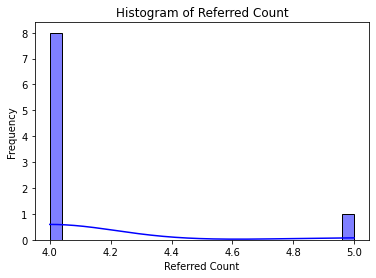

In [12]:
sns.histplot(data=users_per2ip, x='RefCnt', bins=25, kde=True, color='blue')
plt.title('Histogram of Referred Count')
plt.xlabel('Referred Count')
plt.ylabel('Frequency')
plt.show()

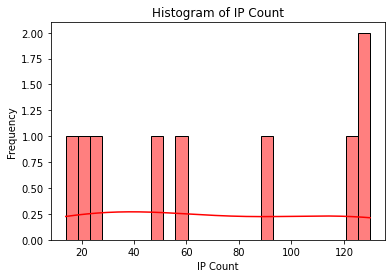

In [13]:
# Plot histogram of IPCount
sns.histplot(data=users_per2ip, x='IPCnt', bins=25, kde=True, color='red')
plt.title('Histogram of IP Count')
plt.xlabel('IP Count')
plt.ylabel('Frequency')
plt.show()

In [14]:
#fraud money transfer flags
gds.run_cypher('MATCH(u:User) RETURN u.fraudMoneyTransfer AS fraudMoneyTransfer, count(u) AS cnt')

,fraudMoneyTransfer,cnt
0,0,33491
1,1,241


In [15]:
# Setting a label for flagged users will enable faster lookups in cypher and faster gds projections
gds.run_cypher('MATCH(u:User) WHERE u.fraudMoneyTransfer=1 SET u:FlaggedUser RETURN count(u)')

,count(u)
0,241


#### Exploring Potential Fraud Patterns with Community Detection

In this example, it is unclear to me what exactly is taking place, and I have a hunch that the fraud activity is not completely labeled given the lack of connectivity and the limited chargeback logic used to flag fraud. At the same time I do not want to simply label every user that shares a card or device with another flagged account, since it is possible that a benign user's device and or card was used fraudulently by another. Since fraudsters are actively avoiding being identified, actors committing fraud are often not just represented by a single user account, but rather by multiple accounts and identifiers which, hopefully for us, share some connections and similarities.

In a graph, we can attempt to roughly identify these fragmented identities with Community Detection, a large set of methods that attempt to partition graphs into well connected groups a.k.a. Communities, where the connectivity in the communities is significantly higher than outside the community. There are multiple forms of community detection. We will use a couple in this post, starting with Louvain.

#### Using Louvain Community Detection

[Louvain](https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/) is useful for exploratory analysis of communities because it uses a form of modularity scoring to split up the graph into hierarchical clusters. This means that your theories around fraud patterns and graph structure don't need to be exact for it to provide informative communities and insights.

I will leverage P2P transactions, cards, and devices for Louvain. We will leave out IP addresses for now since they have some super node issues (we will leverage IP addresses in subsequent parts ). Below are the queries for running Louvain in Neo4j GDS and aggregating community statistics. The last query below orders communities by the count of flagged users so we can further examine some of the more concentrated flagged communities.


In [16]:
%%time
# clear the graph if it exists beforehand
clear_graph_by_name('demo')

# create graph projection
g, _ = gds.graph.project('proj', ['User', 'Card', 'Device'], {
    'HAS_CC': {'orientation': 'UNDIRECTED'},
    'USED': {'orientation': 'UNDIRECTED'},
    'AGGREGATED_P2P': {'type':'P2P', 'orientation': 'NATURAL',
                      'properties': {
                          'numberOfTransactions':{
                              'property': '*',
                              'aggregation': 'COUNT'
                          }
                      }}
})

# run Louvain Algorithm
_ = gds.louvain.write(g, writeProperty='louvainCommunityId')

# write aggregated relationships back for easier visualization
gds.graph.relationship.write(g, relationship_type='AGGREGATED_P2P', 
                                       relationship_property='numberOfTransactions')

#drop the graph
g.drop()
_

Louvain:   0%|          | 0/100 [00:00<?, ?%/s]

Wall time: 8.45 s


writeMillis                                                                                                                                                                                                                                                                                                                                                                                    759
nodePropertiesWritten                                                                                                                                                                                                                                                                                                                                                                       204001
modularity                                                                                                                                                                                                                        

In [17]:
print("Louvain Communities Ordered by count of Flagged Users")
gds.run_cypher('''
    MATCH (u:User)
    WITH u.louvainCommunityId AS communityId,
        count(u) AS userCount,
        sum(u.fraudMoneyTransfer) as flaggedCount
    RETURN communityId,
        userCount,
        flaggedCount,
        toFloat(flaggedCount)/toFloat(userCount) AS flaggedRatio
    ORDER BY flaggedCount DESC LIMIT 100
''')

Louvain Communities Ordered by count of Flagged Users


,communityId,userCount,flaggedCount,flaggedRatio
0,181075,152,7,0.046053
1,182733,7,4,0.571429
2,197014,7,3,0.428571
3,170836,609,3,0.004926
4,188313,6,3,0.500000
...,...,...,...,...
95,190691,4,1,0.250000
96,182752,61,1,0.016393
97,173401,5,1,0.200000
98,174011,20,1,0.050000


We can view communities of users and connecting identifiers in [Neo4j Bloom](https://neo4j.com/docs/bloom-user-guide/current/) or Neo4j Browser with queries of the form:

```cypher
MATCH(u1:User{louvainCommunityId: $id})-[r1:HAS_CC|HAS_IP|USED]->(n)<-[r2:HAS_CC|HAS_IP|USED]-(u2:User{louvainCommunityId: $id})
WITH *
OPTIONAL MATCH (u1)-[:P2P]-(u2)
RETURN *
```
Below are a couple examples of these communities. Flagged users are colored red with caption=0 with other users colored orange and caption=1. We will see an interesting pattern of flagged users sending money to non-flagged users with which they share devices, cards, and IPs. This behavior is suspicious because it suggests that the same individual or group of individuals may be using multiple accounts to withdraw cash from credit transactions prior to a chargeback being executed on the cards. The shared credit card examples (such as example 2 below) are some of the most indicative.

Example 1:
<img src="img/louvain-community-11.png" width="900" >

Example 2:
<img src="img/louvain-community-12.png" width="900" >

This pattern indicates that the receiving user accounts are fraud risk accounts. In the next section we will use these patterns to inform resolution of fraud communities and the labeling of additional fraud risk accounts.

## Resolve Fraud Communities using Entity Resolution and Community Detection


### Entity Resolution Business Rules

For this analysis, we will use some pretty straightforward ER business logic: If one user sent money to another user that shares the same credit card, we will resolve the two user accounts by linking them together with a new relationship type.

You could switch out or add different rules, this is just an example. In a real-world scenario these business rules would pass by SMEs and possibly be backed by further supervised machine learning on manually labeled data. More advanced techniques for this type of ER are possible in graph and we describe them in [this whitepaper](https://neo4j.com/whitepapers/graph-data-science-use-cases-entity-resolution/) and [this blog](https://neo4j.com/developer-blog/exploring-supervised-entity-resolution-in-neo4j/).

For this P2P dataset, we do not necessarily want to label all senders/receivers of flagged user transactions as fraudulent since some fraud schemes involve transactions with victims. Furthermore, additional identifiers such as IP may be inexact and cards + devices can be fraudulently controlled/used without the owners permission. Hence I am using a somewhat stringent rule that aligned with the patterns noted above. 


We can apply relationships to reflect these business rules using cypher:


In [18]:
# P2P with shared card rule
gds.run_cypher('''
    MATCH (u1:User)-[r:P2P]->(u2)
    WITH u1, u2, count(r) AS cnt
    MATCH (u1)-[:HAS_CC]->(n)<-[:HAS_CC]-(u2)
    WITH u1, u2, count(DISTINCT n) AS cnt
    MERGE(u1)-[s:P2P_WITH_SHARED_CARD]->(u2)
    RETURN count(DISTINCT s) AS cnt
''')

,cnt
0,6240


### Using Weakly Connected Components (WCC) to Resolve Communities



In [19]:
# write WCC ids to the graph
clear_graph_by_name('demo')

g, _ = gds.graph.project('demo', ['User'], {
    'P2P_WITH_SHARED_CARD': {'orientation': 'UNDIRECTED'}
})

df = gds.wcc.write(g, writeProperty='wccId')
g.drop()
df

writeMillis                                                                                                                                                                                                                                                                                      79
nodePropertiesWritten                                                                                                                                                                                                                                                                         33732
componentCount                                                                                                                                                                                                                                                                                29329
componentDistribution                                                                                                       

### Labeling Fraud Risk User Accounts

As these communities are meant to label underlying groups of individuals, if even one flagged account is in the community, we will label all user accounts in the group as fraud risks:


In [20]:
gds.run_cypher('''
    MATCH (f:FlaggedUser)
    WITH collect(DISTINCT f.wccId) AS flaggedCommunities
    MATCH(u:User) WHERE u.wccId IN flaggedCommunities
    SET u:FraudRiskUser
    SET u.fraudRisk=1
    RETURN count(u)
''')

,count(u)
0,399


In [21]:
gds.run_cypher('''
    MATCH (u:User) WHERE NOT u:FraudRiskUser
    SET u.fraudRisk=0
''')

""


### Exploring WCC Communities

Similar to Louvain we can view communities of users and connecting identifiers in [Neo4j Bloom](https://neo4j.com/docs/bloom-user-guide/current/) or Browser with queries of the form:

```cypher
MATCH(u1:User{wccId: $id})-[r1:HAS_CC|HAS_IP|USED]->(n)<-[r2:HAS_CC|HAS_IP|USED]-(u2:User{wccId: $id})
WITH *
OPTIONAL MATCH (u1)-[r3:P2P]-(u2)
RETURN *
```
Below are a couple examples. Users that were flagged via initial chargeback logic are colored red with caption=1, while other users are colored orange with caption=0. Overall, you will notice a high degree of overlapping connectivity of identifiers and P2P transactions between users, which we should expect given our ER rules.

Example 1:
<img src="https://github.com/neo4j-product-examples/training-graph-data-science/blob/main/img/wcc-community-12.png?raw=1" width="900" >

Example 2:
<img src="https://github.com/neo4j-product-examples/training-graph-data-science/blob/main/img/wcc-community-11.png?raw=1" width="900" >

### Outcomes of Fraud Risk Labeling
Fraud Risk labeling helped identify an additional 158 new fraud risk user accounts, a 65% increase . We also see that 60% of the money going to/from previously flagged accounts and other users can be attributed to the newly identified risk accounts:

In [22]:
gds.run_cypher('''
   MATCH (:FlaggedUser)-[r:P2P]-(u)  WHERE NOT u:FlaggedUser
   WITH toFloat(sum(r.totalAmount)) AS p2pTotal
   MATCH (u:FraudRiskUser)-[r:P2P]-(:FlaggedUser) WHERE NOT u:FlaggedUser
   WITH p2pTotal,  toFloat(sum(r.totalAmount)) AS fraudRiskP2pTotal
   RETURN round((fraudRiskP2pTotal)/p2pTotal,3) AS p
''').p[0]

0.603

Additionally, while the newly identified 158 accounts represents less than 1% of total users in the sample, 11.9% of the total P2P amount in the sample involved the newly identified accounts as senders or receivers:

In [23]:
gds.run_cypher('''
   MATCH (:User)-[r:P2P]->()
   WITH toFloat(sum(r.totalAmount)) AS p2pTotal
   MATCH (u:FraudRiskUser)-[r:P2P]-() WHERE NOT u:FlaggedUser
   WITH p2pTotal, toFloat(sum(r.totalAmount)) AS fraudRiskP2pTotal
   RETURN round((fraudRiskP2pTotal)/p2pTotal,3) AS p
''').p[0]

0.119

## Part 4: Predict Fraud Risk Accounts with Machine Learning


### Feature Engineering
If we want a machine learning model to successfully classify fraud risk user accounts, we need to supply features that will be informative for the task. The below commands engineer graph features using GDS.  This includes features from [WCC](https://neo4j.com/docs/graph-data-science/current/algorithms/wcc/) community sizes, [PageRank](https://neo4j.com/docs/graph-data-science/current/algorithms/page-rank/), and [Degree Centrality](https://neo4j.com/docs/graph-data-science/current/algorithms/degree-centrality/).

#### Community Features

In [24]:
gds.run_cypher('''
    MATCH (u:User)
    WITH u.wccId AS componentId, count(*) AS communitySize, collect(u) AS users
    WITH communitySize, toInteger(communitySize > 1) AS partOfCommunity, users
    UNWIND users as u
    SET u.communitySize = communitySize
    SET u.partOfCommunity = partOfCommunity;
''')

""


#### P2P With Cards and Id Sharing Centrality Features

In [25]:
# clear the graph if it exists beforehand
clear_graph_by_name('p2p-features')

#project
g, _ = gds.graph.project('p2p-features', ['User'], {
    'P2P': {'type': 'P2P', 'orientation': 'NATURAL', 'aggregation': 'SUM', 'properties': ['totalAmount']},
    'P2P_REVERSE': {'type': 'P2P', 'orientation': 'REVERSE', 'aggregation': 'SUM', 'properties': ['totalAmount']},
    'P2P_WITH_SHARED_CARD': {'type': 'P2P_WITH_SHARED_CARD', 'orientation': 'NATURAL'}
})

# shared card pageRank/influence
gds.pageRank.write(g, relationshipTypes=['P2P_WITH_SHARED_CARD'], maxIterations=1000,
                   writeProperty='p2pSharedCardPageRank')

# P2P sender pageRank/influence
gds.pageRank.write(g, relationshipTypes=['P2P'], maxIterations=1000, writeProperty='p2pSentPageRank')

# P2P reciever pageRank/influence
gds.pageRank.write(g, relationshipTypes=['P2P_REVERSE'], maxIterations=1000, relationshipWeightProperty='totalAmount',
                   writeProperty='p2pReceivedWeightedPageRank')

# P2P reciever wegithed degree centrality
gds.degree.write(g, relationshipTypes=['P2P_REVERSE'], relationshipWeightProperty='totalAmount',
                 writeProperty='p2pReceivedWeightedDegree')
g.drop()

graphName                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       p2p-features
database                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### ID Centrality Features

In [26]:
# clear the graph if it exists beforehand
clear_graph_by_name('p2p-features')

#project
g, _ = gds.graph.project('user-centrality-features', ['User', 'Card', 'Device', 'IP'], ['HAS_CC', 'HAS_IP', 'USED'])

# card count/degree
gds.degree.mutate(g, nodeLabels=['User', 'Card'], relationshipTypes=['HAS_CC'], mutateProperty='cardDegree')

# device count/degree
gds.degree.mutate(g, nodeLabels=['User', 'Device'], relationshipTypes=['USED'], mutateProperty='deviceDegree')

# IP count/degree
gds.degree.mutate(g, nodeLabels=['User', 'IP'], relationshipTypes=['HAS_IP'], mutateProperty='ipDegree')

# write node properties
gds.graph.writeNodeProperties(g, ['cardDegree', 'deviceDegree', 'ipDegree'], ['User'])

g.drop()

graphName                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           user-centrality-features
database                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

### Machine Learning Training & Evaluation

#### Get and Prepare Data

In [27]:
df = gds.run_cypher('''
    MATCH(u:User)
    RETURN u.guid AS guid,
        u.wccId AS wccId,
        u.fraudRisk AS fraudRisk,
        u.fraudMoneyTransfer AS fraudMoneyTransfer,
        u.p2pSharedCardPageRank AS p2pSharedCardPageRank,
        u.p2pSentPageRank AS p2pSentPageRank,
        u.p2pReceivedWeightedPageRank AS p2pReceivedWeightedPageRank,
        u.p2pReceivedWeightedDegree AS p2pReceivedWeightedDegree,
        u.ipDegree AS ipDegree,
        u.cardDegree AS cardDegree,
        u.deviceDegree AS deviceDegree,
        u.communitySize AS communitySize,
        u.partOfCommunity AS partOfCommunity
''')
df

,guid,wccId,fraudRisk,fraudMoneyTransfer,p2pSharedCardPageRank,p2pSentPageRank,p2pReceivedWeightedPageRank,p2pReceivedWeightedDegree,ipDegree,cardDegree,deviceDegree,communitySize,partOfCommunity
0,be0222d26897046dc92ae2929d3427e7,0,0,0,0.150000,0.175456,0.414277,10.0,21.0,3.0,4.0,1,0
1,59515432f0e2e79b83e9524c94f7f86e,1,0,0,0.150000,0.310548,0.150422,10.0,7.0,1.0,1.0,1,0
2,ba1f4324c66ee093478d41a6826a3649,2,0,0,0.150000,0.277500,0.150000,160.0,8.0,2.0,1.0,1,0
3,8a18e1625e35a9f66abfd7bd2d04f0b3,3,0,0,0.150000,0.230174,0.319779,100.0,135.0,12.0,2.0,1,0
4,9f705a0107acc25a57f9e6aa8436a08e,4,0,0,0.150000,0.391426,0.150000,2703.6,169.0,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33727,f3693169dcc9064114a171c5c2f485b5,33727,0,0,0.150000,0.297005,0.451011,5.0,14.0,2.0,2.0,1,0
33728,10f7f048645c602de3fae7c2cf81b254,27913,0,0,0.999999,0.371382,1.632799,150.0,5.0,4.0,4.0,2,1
33729,d3a4469957800636802a8de4874af1bc,33729,0,0,0.150000,0.150000,0.277500,0.0,38.0,2.0,0.0,1,0
33730,4698ccb2e4b07b1974741f634115e49b,33730,0,0,0.150000,0.181054,0.170451,10.0,1.0,1.0,0.0,1,0


In [28]:
X = df.drop(columns=['fraudRisk', 'fraudMoneyTransfer', 'wccId', 'guid'])
y = df.fraudRisk - df.fraudMoneyTransfer

In [29]:
X

,p2pSharedCardPageRank,p2pSentPageRank,p2pReceivedWeightedPageRank,p2pReceivedWeightedDegree,ipDegree,cardDegree,deviceDegree,communitySize,partOfCommunity
0,0.150000,0.175456,0.414277,10.0,21.0,3.0,4.0,1,0
1,0.150000,0.310548,0.150422,10.0,7.0,1.0,1.0,1,0
2,0.150000,0.277500,0.150000,160.0,8.0,2.0,1.0,1,0
3,0.150000,0.230174,0.319779,100.0,135.0,12.0,2.0,1,0
4,0.150000,0.391426,0.150000,2703.6,169.0,9.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...
33727,0.150000,0.297005,0.451011,5.0,14.0,2.0,2.0,1,0
33728,0.999999,0.371382,1.632799,150.0,5.0,4.0,4.0,2,1
33729,0.150000,0.150000,0.277500,0.0,38.0,2.0,0.0,1,0
33730,0.150000,0.181054,0.170451,10.0,1.0,1.0,0.0,1,0


In [30]:
y

0        0
1        0
2        0
3        0
4        0
        ..
33727    0
33728    0
33729    0
33730    0
33731    0
Length: 33732, dtype: int64

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Model Training and Evaluation

For purposes of this demo I am going to use a random forest classifier. Other classifiers including logistic regression, SVM, Neural Nets, and Boosting variants could work as well. Going into the exact pros and cons of these models is out of scope here. Overall, random forest can be relatively accomidating for initial exploration since the approach is relatively robust to feature scaling and collinearity issues while often only requiring only minimal tuning to get working well.

#### Fit sklearn random forest model
Generate Community Based Features using Cypher.  Lets write these to the database for now.

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, random_state=0, max_depth=5, bootstrap=True, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       random_state=0)

Accuracy of random forrest classifier on test set: 0.88

Confusion Matrix: 


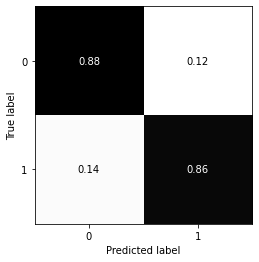

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score, recall_score
print('Accuracy of random forrest classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))
print('\nConfusion Matrix: ')
disp = ConfusionMatrixDisplay.from_predictions(y_test, clf.predict(X_test), display_labels=clf.classes_,
                                               normalize='true', cmap='Greys', colorbar=False)

In [34]:
# Generate predictions for the test set
y_pred = clf.predict(X_test)

# Calculate F1 score, precision, and recall
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# Print the results
print('F1 Score: {:.2f}'.format(f1))
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))


F1 Score: 0.93
Precision: 1.00
Recall: 0.88


- If minimizing false positives (incorrectly flagging non-fraudulent transactions as fraudulent) is important to reduce operational costs and avoid inconveniencing customers, then precision should be prioritized.
- If minimizing false negatives (failing to catch fraudulent transactions) is critical to protect the company and customers from financial loss, then recall should be prioritized.

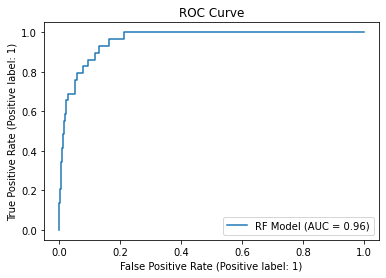

In [35]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_estimator(clf, X_test, y_test, name="RF Model")
_ = display.ax_.set_title("ROC Curve")

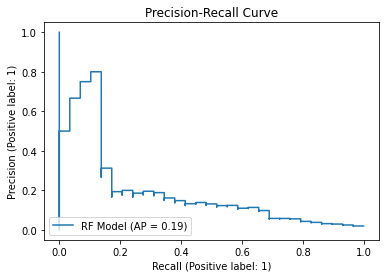

In [36]:
from sklearn.metrics import PrecisionRecallDisplay

y_prob = clf.predict_proba(X_test)
display = PrecisionRecallDisplay.from_predictions(y_test, y_prob[:, 1], name="RF Model")
_ = display.ax_.set_title("Precision-Recall Curve")

Below is a ranked list of the most influential features. Among the most important are the community sizes and the shared ids degree and p2p shared card pageRank.

In [37]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_train, y_train, random_state=0)
pd.DataFrame(abs(result['importances_mean']),index=X_train.columns).sort_values(0, ascending=False)

,0
communitySize,0.085522
partOfCommunity,0.082157
p2pSharedCardPageRank,0.076124
ipDegree,0.004136
p2pReceivedWeightedDegree,0.004010
deviceDegree,0.003165
p2pSentPageRank,0.002135
cardDegree,0.001905
p2pReceivedWeightedPageRank,0.000052


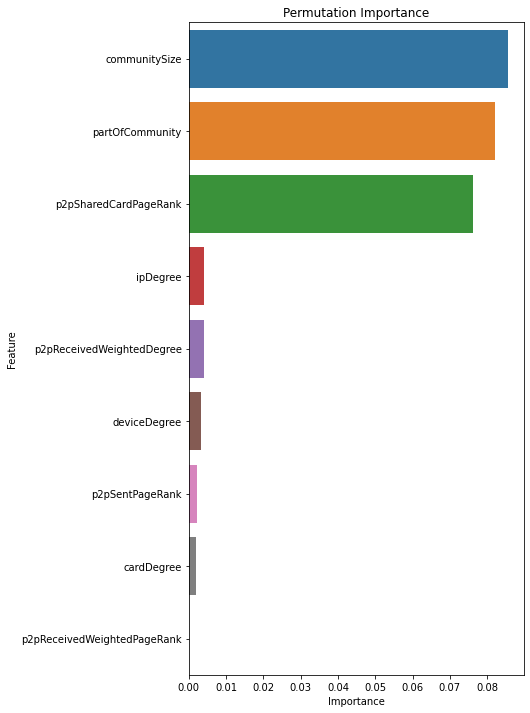

In [38]:
importances_df = pd.DataFrame(abs(result['importances_mean']), index=X_train.columns, columns=['importance'])
sorted_importances_df = importances_df.sort_values('importance', ascending=False)

plt.figure(figsize=(6, 12))
sns.barplot(x=sorted_importances_df['importance'], y=sorted_importances_df.index)
plt.title('Permutation Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Investigating Unlabeled High-Probability Fraud Risk Predictions
The labeling from part 2 wasn't perfect. Now that we have trained a machine learning model, investigating user accounts that were predicted as high probability fraud risks despite not being labeled as such by us (ostensible false positives), will bring further insights.

In [39]:
# Retrieve High Probability predictions for non-fraud risk labeled data in the testset
y_test_df = y_test.to_frame(name='cls')
y_test_df['predictedProbability']=y_prob[:, 1]
test_prob_df = y_test_df[(y_test_df.predictedProbability > 0.9) & (y_test_df.cls == 0)]\
    .join(df[['guid','wccId', 'communitySize']]).sort_values('predictedProbability', ascending=False)
test_prob_df

,cls,predictedProbability,guid,wccId,communitySize
10344,0,0.945875,bf39047c8f385a0a6657217c1b052858,363,7
30348,0,0.901191,008cc9b3a7a3f5706654dd9993889578,5193,5
31053,0,0.900124,1726639c416c87f3ba18b2dad78b8ad3,23868,2


In [40]:
#Write back to database for investigation in Bloom
gds.run_cypher('''
    UNWIND $predictRecords AS p
    MATCH(u:User) WHERE u.guid = p.guid
    SET u.predictedProbability = p.predictedProbability
    SET u:PredictedFraudRisk
''', params = {'predictRecords':test_prob_df.to_dict(orient='records')})

""


Below are a couple examples from the test set visualized in [Bloom](https://neo4j.com/docs/bloom-user-guide/current/) . The larger, leftmost, green nodes with user icons represent the high probability nodes of interest.
You can use the below query to explore yourself:
```cypher
MATCH(p:PredictedFraudRisk)
WITH COLLECT(p.wccId) AS wccIds
MATCH(u1:User) WHERE u1.wccId IN wccIds
MATCH(u2:User) WHERE u2.wccId IN wccIds
WITH u1, u2
MATCH(u1)-[r1:HAS_CC|HAS_IP|USED]->(n)<-[r2:HAS_CC|HAS_IP|USED]-(u2)
WITH *
OPTIONAL MATCH (u1)-[r3:P2P]-(u2)
RETURN *
```
Example 1
<img src="https://github.com/neo4j-product-examples/training-graph-data-science/blob/main/img/predictions-in-bloom-1.png?raw=1" width="700" >

Example 2
<img src="https://github.com/neo4j-product-examples/training-graph-data-science/blob/main/img/predictions-in-bloom-2.png?raw=1" width="700" >


## Clean Up
This section will help clean all the additional graph elements and properties created in the above workflow.

In [41]:
# delete created relationships
gds.run_cypher('MATCH (:User)-[r:P2P_WITH_SHARED_CARD]->() DELETE r')
gds.run_cypher('MATCH (:User)-[r:AGGREGATED_P2P]->() DELETE r')

""


In [42]:
gds.run_cypher('MATCH (:User)-[r:AGGREGATED_P2P]->() DELETE r')

""


In [43]:
# remove created node Labels
gds.run_cypher('MATCH (u:FlaggedUser) REMOVE u:FlaggedUser')
gds.run_cypher('MATCH (u:FraudRiskUser) REMOVE u:FraudRiskUser')
gds.run_cypher('MATCH (u:FraudSharedId) REMOVE u:FraudSharedId')
gds.run_cypher('MATCH (u:PredictedFraudRisk) REMOVE u:PredictedFraudRisk')

""


In [44]:
# remove created node properties
gds.run_cypher('''
    MATCH (n)
    REMOVE n.wccId,
        n.sharedIdsDegree,
        n.predictedProbability,
        n.partOfCommunity,
        n.p2pSharedCardPageRank,
        n.p2pSharedCardDegree,
        n.p2pSentWeightedPageRank
''')

""


In [45]:
# remove created node properties
gds.run_cypher('''
    MATCH (n)
    REMOVE 
        n.p2pSentWeightedDegree,
        n.p2pSentPageRank,
        n.p2pSentDegree,
        n.p2pReversedSharedCardPageRank,
        n.p2pReversedSharedCardDegree,
        n.p2pReceivedWeightedPageRank,
        n.p2pReceivedWeightedDegree,
        n.p2pReceivedPageRank
''')

""


In [46]:
# remove created node properties
gds.run_cypher('''
    MATCH (n)
    REMOVE 
        n.p2pReceivedDegree,
        n.louvainCommunityId,
        n.ipDegree,
        n.fraudRiskRatio,
        n.fraudRiskDegree,
        n.fraudRisk
''')

""


In [47]:
# remove created node properties
gds.run_cypher('''
    MATCH (n)
    REMOVE 
        n.flaggedRatio,
        n.flaggedDegree,
        n.deviceDegree,
        n.degree,
        n.communitySize,
        n.cardDegree
''')

""


In [48]:
# remove created relationship properties
gds.run_cypher('MATCH ()-[r]->() REMOVE r.inverseDegreeWeight')

""
